In [1]:
import numpy as np
import torch
import functools
import time
import matplotlib.pyplot as plt

In [2]:
def poly(*a):
    """
    :param a: a list of coefficients starting with the coefficient of the highest degree down to 0.
    :return: same as numpy.poly1d(a)
    """
    return np.poly1d(a)

def NOISY(noise):
    def decorate(function):
        def wrapper(*args, **kwargs):
            result = function(*args, **kwargs)
            result+=np.random.randn()*noise
            return result
        return wrapper
    return decorate

In [3]:
def find_roots(p: np.poly1d, start, end, maxerr=0.001):
    global base_poly_roots_finders
    coefs = p.coefficients
    d = p.order
    if d < len(base_poly_roots_finders):
        return base_poly_roots_finders[d](start, end, *coefs)
    dp_roots = find_roots(np.polyder(p), start, end)
    return find_roots_from_der_roots(p, start, dp_roots, end, maxerr)

def _find_roots_poly_constant(start, end, constant):
    if constant == 0:
        raise Exception("Zero polynomial has infinite amount roots")
    return []
def _find_roots_poly_linear_line(start, end, slope, constant):
    if slope == 0:
        return _find_roots_poly_constant(start, end, constant)
    root = (-constant) / slope
    return _roots_list(start, end, root)
def _find_roots_poly_quadratic(start, end, a, b, c):
    if a == 0:
        return _find_roots_poly_linear_line(start, end, b ,c)
    return _find_roots_poly_quadratic_core(a, b, c, end, start)

def _find_roots_poly_quadratic_core(a, b, c, end, start):
    delta = (b ** 2) - 4 * a * c
    if delta < 0:
        return []
    elif delta == 0:
        root = -b / (2 * a)
        return _roots_list(start, end, root)
    else:
        return _find_roots_poly_quadratic_2_roots(a, b, delta, end, start)

def _find_roots_poly_quadratic_2_roots(a, b, delta, end, start):
    delta = np.sqrt(delta)
    root0 = (-b + delta) / (2 * a)
    root1 = (-b - delta) / (2 * a)
    root0, root1 = min(root0, root1), max(root0, root1)
    return _roots_list(end, start, root0, root1)


base_poly_roots_finders = [
    _find_roots_poly_constant,
    _find_roots_poly_linear_line,
    _find_roots_poly_quadratic
]

def _roots_list(end, start, *roots):
    return [root for root in roots if start <= root <= end]

def find_poly_roots(p, a, dp_roots, b, maxerr):
    roots = []

    prev_a = a
    p_prev_a = p(a)
    if is_root(p_prev_a, maxerr):
        roots.append(prev_a)

    for i in range(len(dp_roots)):
        dpr = dp_roots[i]
        p_dpr = p(dpr)
        if is_root(p_dpr, maxerr):
            roots.append(dpr)
        elif (p_prev_a < 0) != (p_dpr < 0):
            roots.append(regula_falsi(p, prev_a, dpr, maxerr))
        else:
            pass
        prev_a = dpr
        p_prev_a = p_dpr

    p_b = p(b)
    if is_root(p_b, maxerr):
        roots.append(b)
    elif (p_prev_a < 0) != (p_b < 0):
        roots.append(regula_falsi(p, prev_a, b, maxerr))
    else:
        pass
    return roots

def is_root(y, maxerr):
    return abs(y) <= maxerr

def regula_falsi(f, a, b, maxerr):
    c = b
    fc = fb = f(b)
    while not is_root(fc, maxerr):
        c = b - fb * ((b - a) / (fb - f(a)))
        fc = f(c)
        if (fc < 0) != (fb < 0):
            a = c
        else:
            b = c
            fb = fc
    return c


def poly_to_string(p):
    coefficients = p.coefficients
    highest = coefficients[0]
    n = p.order

    s = ""
    if highest == -1:
        s += "-"
    elif highest == 1:
        pass
    else:
        s += str(highest)
    if n >= 10:
        s += f"x^{{{n}}}"
    elif n > 1:
        s += f"x^{n}"
    elif n == 1:
        s += "x"
    for k in range(1, n - 1):
        coef_string = coef_to_string(coefficients[k])
        if coef_string == "":
            continue
        s += f"{coef_string}x^{n-k}"

    if n > 1:
        coef_string = coef_to_string(coefficients[n - 1])
        if coef_string != "":
            s += f"{coef_string}x"
    if n > 0:
        coef = coefficients[n]
        s += f" {'-' if coef < 0 else '+'} {abs(coef)}"
    return s


def coef_to_string(coef):
    s = ""
    if coef != 0:
        s += f" {'-' if coef < 0 else '+'} "
        if abs(coef) != 1:
            s += str(abs(coef))
    return s

In [4]:
def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt(((x1 - x2) ** 2) + ((y1 - y2) ** 2))

def convert_torch_to_numpy(l):
    return [np.float64(x) for x in l]

class Assignment4A:
    def __init__(self):
        """
        Here goes any one time calculation that need to be made before 
        solving the assignment for specific functions. 
        """
        self.Ms = [self.build_M(d) for d in range(13)]

    def fit(self, f: callable, a: float, b: float, d:int, maxtime: float) -> callable:
        """
        Build a function that accurately fits the noisy data points sampled from
        some closed shape. 
        
        Parameters
        ----------
        f : callable. 
            A function which returns an approximate (noisy) Y value given X. 
        a: float
            Start of the fitting range
        b: float
            End of the fitting range
        d: int 
            The expected degree of a polynomial matching f
        maxtime : float
            This function returns after at most maxtime seconds. 

        Returns
        -------
        a function:float->float that fits f between a and b
        """
        start_time = time.time()
        n = 10
        M = self.Ms[d] if d < len(self.Ms) else self.build_M(d)
        fit_func = self.fit_core(f, a, b, n, d, M)

#         fit_func_in_thread = None
#         def run_fit_core():
#             nonlocal fit_func_in_thread
#             fit_func_in_thread = self.fit_core(f, a, b, int(n), d, M)

#         n = (b - a) * 1000
#         in_slow_start = True
#         slow_start_threshold = (b - a) * d * 1000
#         time_left = maxtime - (time.time() - start_time)
#         while time_left > 0:
#             fit_thread = threading.Thread(target=run_fit_core)
#             fit_thread.setDaemon(True)
#             fit_thread.setName("4A Fitting")

#             fit_thread.start()
#             time_left = maxtime - (time.time() - start_time)
#             fit_thread.join(time_left - 0.02)
#             if fit_thread.is_alive():
#                 return fit_func
#             else:
#                 fit_func = fit_func_in_thread

#             if in_slow_start:
#                 n_temp = n * 2.5
#                 if n_temp > slow_start_threshold:
#                     in_slow_start = False
#                     n = min(n_temp, slow_start_threshold + 1000)
#             else:
#                 n += 2000
#             time_left = maxtime - (time.time() - start_time)

        return fit_func

    def fit_core(self, f: callable, a: float, b: float, n: int, d: int, M):
        #x_samples = np.concatenate([[a], (np.random.random(n - 2) * (b - a)) + a, [b]])
        #x_samples.sort()
        x_samples = torch.linspace(a, b, n, dtype=torch.float64)
        y_samples = torch.from_numpy(f(x_samples))

        dis = [0] * n
        def sum_d(acc, i):
            d = acc + euclidean_distance(x_samples[i], y_samples[i], x_samples[i - 1], y_samples[i - 1])
            dis[i] = d
            return d
        d_total = functools.reduce(sum_d, range(1, n), 0)

        t_dis = torch.tensor([dis[i] / d_total for i in range(n)], dtype=torch.float64)
        print(f"M: {M.size()}\n{M}\n")
        P = torch.stack([x_samples, y_samples]).T
        print(f"P: {P.size()}\n{P}\n")
        print(f"d total: {d_total}, dis: {dis}")
        print(f"t_dis: {t_dis}\n")
        
        T = torch.stack([t_dis ** k for k in range(d, -1, -1)]).T
        print(f"T: {T.size()}\n{T}\n")
        C = M.inverse().mm((T.T.mm(T)).inverse()).mm(T.T).mm(P)
        print(f"C: {C.size()}\n{C}\n")
        bezier_curve = M.mm(C).T
        T2 = T.T
        print(f"T^T: {T2}")
        T2 = T2.mm(T)
        print(f"T^T * T: {T2}")
        T2 = T2.inverse()
        print(f"(T^T * T)^-1: {T2}")
        T3 = T.T
        print(f"T^T: {T3}")
        T2 = T2.mm(T3)
        print(f"((T^T * T)^-1) * T^T: {T2}")
        T2 = T2.mm(P)
        print(f"B^T: {T2}")
        T2 = T2.T
        print(f"B: {T2}")
        bezier_x_poly = np.poly1d(convert_torch_to_numpy(bezier_curve[0]))
        bezier_y_poly = np.poly1d(convert_torch_to_numpy(bezier_curve[1]))
        print(f"Bezier: {bezier_curve.size()}\n{bezier_curve}\n")

        def find_t(x):
#             if x == a:
#                 t = 0
#                 #print(f"matched x={x} with t={t}")
#             elif x == b:
#                 t = 1
#                 #print(f"matched x={x} with t={t}")
#             else:
#                 t = find_t_in_interval(x)
            t = find_t_in_interval(x)
            return t
        def find_t_in_interval(x):
            ts = [root.real for root in (bezier_x_poly - x).roots if root.imag == 0 and -0.15 < root.real < 1.1]
            ts.sort()
            estimated_t = (x - a) / (b - a)
#             t = estimated_t
            if len(ts) == 0:
#                 t = estimated_t
                raise Exception(f"No t matching x={x}")
            elif len(ts) == 1:
                t = ts[0]
                #print(f"matched x={x} with t={t}")
            else:
#                 t = ts[0]
#                 t = ts[0]
#                 for i in range(1, len(ts)):
#                     ti = ts[i]
#                     if ti > estimated_t:
#                         break
#                     t = ti
#                 if estimated_t <= 0.5:
#                     t = ts[0]
#                     for i in range(1, len(ts)):
#                         ti = ts[i]
#                         if ti > estimated_t:
#                             break
#                         t = ti
#                 else:
#                     t = ts[len(ts) - 1]
#                     for i in range(len(ts) - 2, -1, -1):
#                         ti = ts[i]
#                         if ti < estimated_t:
#                             break
#                         t = ti
                t = min(ts, key=lambda x: abs(x - estimated_t))
                print(f"{estimated_t}, matched x={x} with {ts}, took {t}")
            return t
        def fit_func(x):
            return bezier_y_poly(find_t(x))

        return fit_func, bezier_curve, bezier_x_poly, bezier_y_poly, T, C, P, M

    def build_M(self, d: int):
        # took code from stackoverflow on how to efficiently calculate a pascal's triangle row
        #see https://stackoverflow.com/questions/15580291/how-to-efficiently-calculate-a-row-in-pascals-triangle
        m = d + 1
        M = torch.zeros([m, m], dtype=torch.float64)

        d_choose_i = 1
        for control_point_index in range(m):
            one_minus_t_power = d - control_point_index
            power_choose_t = 1 if (d + control_point_index) % 2 == 0 else -1
            for choose_1_amount in range(one_minus_t_power + 1):
                M[choose_1_amount][control_point_index] = d_choose_i * power_choose_t
                power_choose_t *= -(one_minus_t_power - choose_1_amount) / (choose_1_amount + 1)
            d_choose_i *= (d - control_point_index) / (control_point_index + 1)
        return M

In [7]:
f = NOISY(1)(poly(1, 1, 1))
a4a = Assignment4A()
t_s = time.time()
a, b = -6, 6
d = 10
fit_func, bezier_curve, bezier_x_poly, bezier_y_poly, T, C, P, M = a4a.fit(f=f, a=a, b=b, d=d, maxtime=5)
t_s = time.time() - t_s

M: torch.Size([11, 11])
tensor([[ 1.0000e+00, -1.0000e+01,  4.5000e+01, -1.2000e+02,  2.1000e+02,
         -2.5200e+02,  2.1000e+02, -1.2000e+02,  4.5000e+01, -1.0000e+01,
          1.0000e+00],
        [-1.0000e+01,  9.0000e+01, -3.6000e+02,  8.4000e+02, -1.2600e+03,
          1.2600e+03, -8.4000e+02,  3.6000e+02, -9.0000e+01,  1.0000e+01,
          0.0000e+00],
        [ 4.5000e+01, -3.6000e+02,  1.2600e+03, -2.5200e+03,  3.1500e+03,
         -2.5200e+03,  1.2600e+03, -3.6000e+02,  4.5000e+01,  0.0000e+00,
          0.0000e+00],
        [-1.2000e+02,  8.4000e+02, -2.5200e+03,  4.2000e+03, -4.2000e+03,
          2.5200e+03, -8.4000e+02,  1.2000e+02,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 2.1000e+02, -1.2600e+03,  3.1500e+03, -4.2000e+03,  3.1500e+03,
         -1.2600e+03,  2.1000e+02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-2.5200e+02,  1.2600e+03, -2.5200e+03,  2.5200e+03, -1.2600e+03,
          2.5200e+02,  0.0000e+00,  0.0000e+00,

0.0, matched x=-6.0 with [-1.0275516981229089e-08, 0.7993180641361755, 0.9996157708210707], took -1.0275516981229089e-08
0.05263157894736844, matched x=-5.368421052631579 with [0.0006329861021720077, 0.7987204612404252, 0.999650783817492], took 0.0006329861021720077
0.10526315789473688, matched x=-4.7368421052631575 with [0.0012848848483966316, 0.16002948083294963, 0.1667272220227951, 0.7981136346952268, 0.9996857563773858], took 0.16002948083294963
0.15789473684210523, matched x=-4.105263157894737 with [0.0019570929418265925, 0.13609602089727896, 0.20307830671662241, 0.7974972076274771, 0.9997206886113572], took 0.13609602089727896
0.21052631578947367, matched x=-3.473684210526316 with [0.002651193303803835, 0.1263248538766957, 0.23629491379482287, 0.7968707779348277, 0.9997555806295224], took 0.23629491379482287
0.2631578947368421, matched x=-2.8421052631578947 with [0.00336897673121152, 0.11912313707018025, 0.3559719498655901, 0.7962339158902859, 0.9997904325414729], took 0.35597194

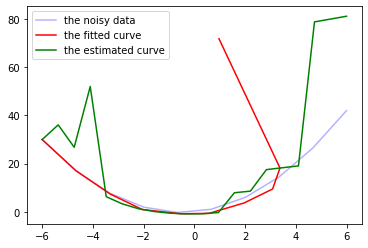

In [8]:
# print(f"M: {M.size()}\n{M}\n")
# print(f"T: {T.size()}\n{T}\n")
# print(f"P: {P.size()}\n{P}\n")
# print(f"C: {C.size()}\n{C}\n")
# print(f"Bezier: {bezier_curve.size()}\n{bezier_curve}\n")
# print(f"{poly_to_string(bezier_x_poly)}\n{poly_to_string(bezier_y_poly)}")

#get the new curve
pts_real_x = np.linspace(a, b, 20)
pts_real_y = [fit_func(x) for x in pts_real_x]
pts = T.mm(M).mm(C).T
plt.plot(P.T[0],P.T[1],alpha=0.3, color="blue", label="the noisy data")
#plt.scatter(C.T[0],C.T[1], color="red", label="inferred control points")
plt.plot(pts[0], pts[1], color="red", label="the fitted curve")
plt.plot(pts_real_x, pts_real_y, color="green", label="the estimated curve")
plt.legend()
#plt.axis([-1, -0.5, 1.4, 1.8])
plt.show()